## Transformer from scartch

from NLP2025 chula.

In [2]:
# !curl -LO https://github.com/Knight-H/thai-lm/raw/refs/heads/master/data/pra-apai-manee-ch1-50.txt

## Library 

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import lightning as L
from datetime import datetime

d:\mini\envs\pine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data 

In [4]:
with open('pra-apai-manee-ch1-50.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("Length of dataset in characters: ", len(text))
# let's look at the first 1000 characters
print(text[:1000])

Length of dataset in characters:  1100605
๏ แต่ปางหลังยังมีกรุงกษัตริย์
สมมุติวงศ์ทรงนามท้าวสุทัศน์	ผ่านสมบัติรัตนานามธานี
อันกรุงไกรใหญ่ยาวสิบเก้าโยชน์	ภูเขาโขดเป็นกำแพงบุรีศรี
สะพรึบพร้อมไพร่ฟ้าประชาชี	ชาวบุรีหรรษาสถาวร
มีเอกองค์นงลักษณ์อัครราช	พระนางนาฏนามปทุมเกสร
สนมนางแสนสุรางคนิกร	ดังกินนรน่ารักลักขณา
มีโอรสสององค์ล้วนทรงลักษณ์	ประไพพักตร์เพียงเทพเลขา
ชื่ออภัยมณีเป็นพี่ยา	พึ่งแรกรุ่นชันษาสิบห้าปี
อันกุมารศรีสุวรรณนั้นเป็นน้อง	เนื้อดังทองนพคุณจำรูญศรี
พึ่งโสกันต์ชันษาสิบสามปี	พระชนนีรักใคร่ดังนัยนา
สมเด็จท้าวบิตุรงค์ดำรงราชย์	แสนสวาทลูกน้อยเสน่หา
จะเสกสองครองสมบัติขัตติยา	แต่วิชาสิ่งใดไม่ชำนาญ
จึงดำรัสเรียกพระโอรสราช	มาริมอาสน์แท่นสุวรรณแล้วบรรหาร
พ่อจะแจ้งเจ้าจงจำคำโบราณ	อันชายชาญเชื้อกษัตริย์ขัตติยา
ย่อมพากเพียรเรียนไสยศาสตร์เวท	สิ่งวิเศษสืบเสาะแสวงหา
ได้ป้องกันอันตรายนครา	ตามกษัตริย์ขัตติยาอย่างโบราณ
พระลูกรักจักสืบวงศ์กษัตริย์	จงรีบรัดเสาะแสวงแห่งสถาน
หาทิศาปาโมกข์ชำนาญชาญ	เป็นอาจารย์พากเพียรเรียนวิชา ฯ
๏ บัดนั้นพี่น้องสองกษัตริย์	ประนมหัตถ์อภิวันท์ด้วยหรรษา
จึงทูลความตามจิตเจ

## Create character tokenizer

In [5]:
# Quick implementation of character tokenizer
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"All Characters: {''.join(chars)}")
print(f"Vocab Size: {vocab_size}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) } #tick create dictionary 
itos = { i:ch for i,ch in enumerate(chars) }

All Characters: 	
 กขคฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรฤลฦวศษสหฬอฮฯะัาำิีึืุูเแโใไๅ็่้๊๋์๏
Vocab Size: 71


In [6]:
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("สวัสดีครับ"))
print(decode(encode("สวัสดีครับ")))

[42, 39, 49, 42, 20, 53, 5, 35, 49, 26]
สวัสดีครับ


## Data splitting

In [7]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

torch.Size([1100605]) torch.int64


In [8]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Data loader

In [9]:
# hyperparameters
batch_size = 16 # B: how many independent sequences will we process in parallel?
seq_len = 256    # T: what is the maximum context length for predictions?
n_embd = 64     # C: text embedding size
n_head = 4      # number of heads
n_layer = 4     # number of blocks
max_iters = 5000
eval_interval = 250
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
dropout = 0.0

torch.manual_seed(42)


In [10]:
len(train_data[3:3+seq_len])

#X = 'พระอภ'   # self.data[0:5]
#Y = 'ระอภัย'  # self.data[1:6]

#character level but GPT using subword 

256

In [11]:
class TextDataset(torch.utils.data.Dataset):
  def __init__(self, data, seq_len):
    self.data = data
    self.seq_len = seq_len

  def __getitem__(self, idx):
    return self.data[idx:idx+seq_len], self.data[idx+1:idx+seq_len+1] #x,y
  
  def __len__(self):
    return len(self.data)-seq_len


In [13]:
train_dataset = TextDataset(train_data, seq_len)
val_dataset = TextDataset(val_data, seq_len)
print(train_dataset[0])

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size, shuffle=False)


#epoch 1: พร > ระ,กำ > ำล
#epoch 2: กำ > ำล,พร > ระ 

(tensor([70,  2, 59, 21, 65, 27, 50,  7, 43, 37, 49,  7, 34, 49,  7, 33, 53,  3,
        35, 56,  7,  3, 41, 49, 21, 35, 52, 34, 69,  1, 42, 33, 33, 56, 21, 52,
        39,  7, 40, 69, 23, 35,  7, 25, 50, 33, 23, 66, 50, 39, 42, 56, 23, 49,
        40, 25, 69,  0, 28, 65, 50, 25, 42, 33, 26, 49, 21, 52, 35, 49, 21, 25,
        50, 25, 50, 33, 24, 50, 25, 53,  1, 45, 49, 25,  3, 35, 56,  7, 62,  3,
        35, 61, 43, 13, 65, 34, 50, 39, 42, 52, 26, 58,  3, 66, 50, 60, 34, 10,
        25, 69,  0, 32, 57, 58,  4, 50, 60,  4, 20, 58, 27, 64, 25,  3, 51, 59,
        30,  7, 26, 56, 35, 53, 40, 35, 53,  1, 42, 48, 30, 35, 54, 26, 30, 35,
        66, 45, 33, 62, 30, 35, 65, 31, 66, 50, 27, 35, 48, 10, 50, 10, 53,  0,
        10, 50, 39, 26, 56, 35, 53, 43, 35, 35, 41, 50, 42, 22, 50, 39, 35,  1,
        33, 53, 58, 45,  3, 45,  7,  5, 69, 25,  7, 37, 49,  3, 41, 19, 69, 45,
        49,  5, 35, 35, 50, 10,  0, 30, 35, 48, 25, 50,  7, 25, 50, 15, 25, 50,
        33, 27, 23, 56, 33, 58,  3, 42,

## Part 1: Self-Attention Head (Scaled Dot-Product Attention)

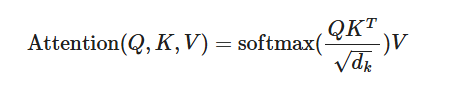

In [19]:
B,T,C = batch_size,seq_len,n_embd # batch, time, embedding dim
head_size = n_embd//n_head    # 16

In [26]:
torch.manual_seed(42)
x = torch.randn(B,T,C)
x.shape #All 

torch.Size([16, 256, 64])

In [ ]:
#create weights and break down head
query = nn.Linear(n_embd , head_size , bias=False)
key = nn.Linear(n_embd , head_size, bias=False)
value = nn.Linear(n_embd , head_size, bias=False)

#calculate 
q = query(x) # == x @ query.weight.T
k = key(x)
v = value(x)

print(q.size())
print(k.size())
print(v.size())

torch.Size([16, 256, 16])
torch.Size([16, 256, 16])
torch.Size([16, 256, 16])


In [36]:
print(len(v)) #batch
print(v[:2]) #choose batch 0,1

16
tensor([[[-0.7776,  0.1929, -0.6711,  ..., -0.9871,  0.2234,  0.8314],
         [ 0.1475, -1.1899, -0.0600,  ..., -0.2166,  0.6814,  0.1309],
         [-0.3895, -0.4664, -0.5744,  ..., -0.1073, -0.6300,  0.3720],
         ...,
         [ 0.7237,  0.3410,  1.0491,  ...,  0.0560,  0.8926, -0.0649],
         [ 0.2497,  0.8039,  1.1446,  ..., -0.1940, -0.8325, -0.1562],
         [ 0.6711, -1.5319,  0.2693,  ...,  0.2329,  0.8364, -0.1013]],

        [[ 0.3186,  0.2224, -0.7357,  ...,  0.5152,  0.7733, -0.7578],
         [ 0.2936,  0.3072, -0.4617,  ...,  0.2525,  0.1408,  0.7226],
         [ 0.6220, -0.9523,  0.0168,  ..., -0.0108, -0.3696, -0.6188],
         ...,
         [-0.0618, -0.9236,  0.0246,  ..., -0.7039,  0.8766,  0.3373],
         [ 0.7416,  0.2209, -0.6881,  ..., -0.4961,  0.6540,  0.6887],
         [-1.2336, -0.0628, -0.1185,  ...,  0.6429,  1.6340, -0.3923]]],
       grad_fn=<SliceBackward0>)


In [52]:
print(len(v[0])) #all token in batch 0
print(v[0][:2]) #choose 2 tokens embedding vector like 'ฉ' has 16 embedding

256
tensor([[-0.7776,  0.1929, -0.6711,  0.3857,  0.4316,  0.0201,  0.0026, -1.6102,
         -0.1988,  0.3434,  1.1472, -0.4292, -0.5048, -0.9871,  0.2234,  0.8314],
        [ 0.1475, -1.1899, -0.0600,  0.3379,  0.1921,  0.3047,  0.3654, -0.3442,
          0.0735,  0.1809,  0.2003, -0.5290,  0.0247, -0.2166,  0.6814,  0.1309]],
       grad_fn=<SliceBackward0>)


In [ ]:
print(len(k[0])) #all token in batch 0
print(k[0][:2]) #choose 2 tokens embedding vector like 'ฉ' has 16 embedding

#next step dot product all token 

256
tensor([[-1.0709, -1.1625,  0.0260,  0.3891, -0.5746,  0.1046, -0.5273,  0.1213,
          1.1707,  0.2108,  0.4636,  0.3899,  1.4501, -0.0414,  0.9155,  0.0261],
        [ 0.1026,  0.2099,  0.0726, -0.5828,  0.4208,  0.5426, -0.1726,  0.8793,
          0.3651,  0.1302, -0.0485, -0.0890,  0.4181,  0.0847,  0.9100, -0.5444]],
       grad_fn=<SliceBackward0>)


In [ ]:
#ex 
torch.matmul(q[0][0], k[0][:3].T) #like 'ฉ' > 'ฉ','ก','ข'
#q[0][0] != k[0][0]   # Not necessary value = 1 because different linear layer and k is meaning focus ส่วนมากไม่ต้องสนใจตัวเอง 

tensor([-3.0448,  0.9179,  0.2035], grad_fn=<SqueezeBackward4>)

In [50]:
# (B, T, d_k) → (B, d_k, T)
# (B, T, d_k) @ (B, d_k, T) → (B, T, T)

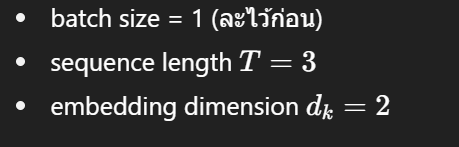

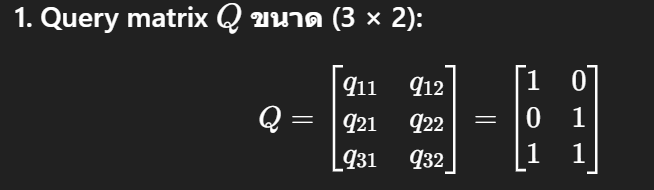

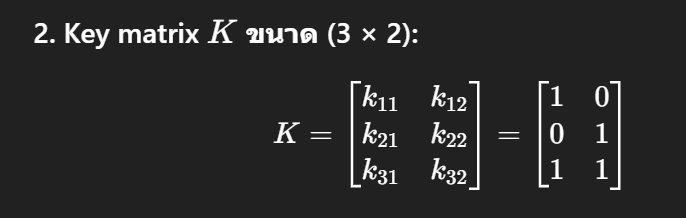

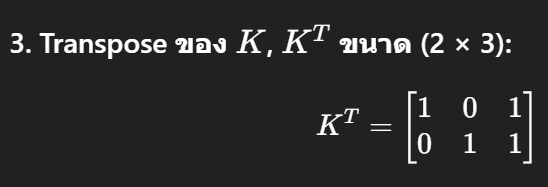

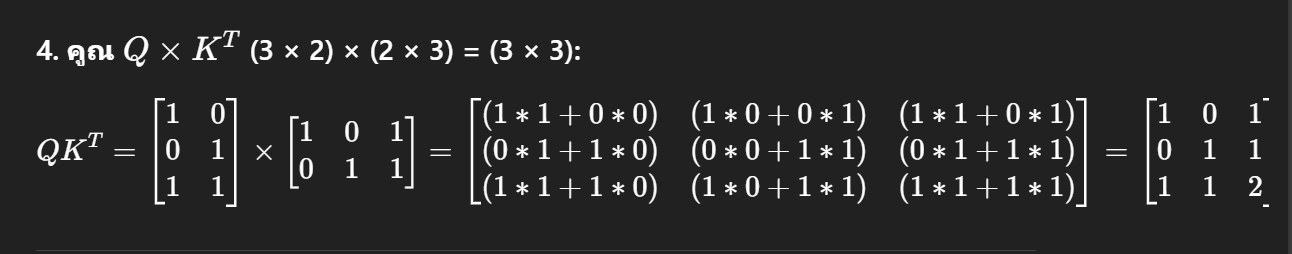

Q = torch.tensor([   
    [0, 1, 1],  # ฉัน   
    [1, 0, 0],  # กิน    
    [0, 0, 1],  # ข้าว   
])  # shape = (3, 3)   
    
K = torch.tensor([    
    [0, 1, 0],  # ฉัน   
    [1, 0, 0],  # กิน   
    [0, 0, 1],  # ข้าว   
])  # shape = (3, 3)    
    
  K.T   
          ⬇   
      [0 1 0]   
      [1 0 0]   
      [0 0 1]  
   
   
Q @ K.T =    
[    
 [1, 0, 1],  # ฉันกับทุกตัว  
 [0, 1, 0],  # กินกับทุกตัว    
 [0, 0, 1],  # ข้าวกับทุกตัว   
]   

In [51]:
wei = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
wei.shape #attention score 

torch.Size([16, 256, 256])

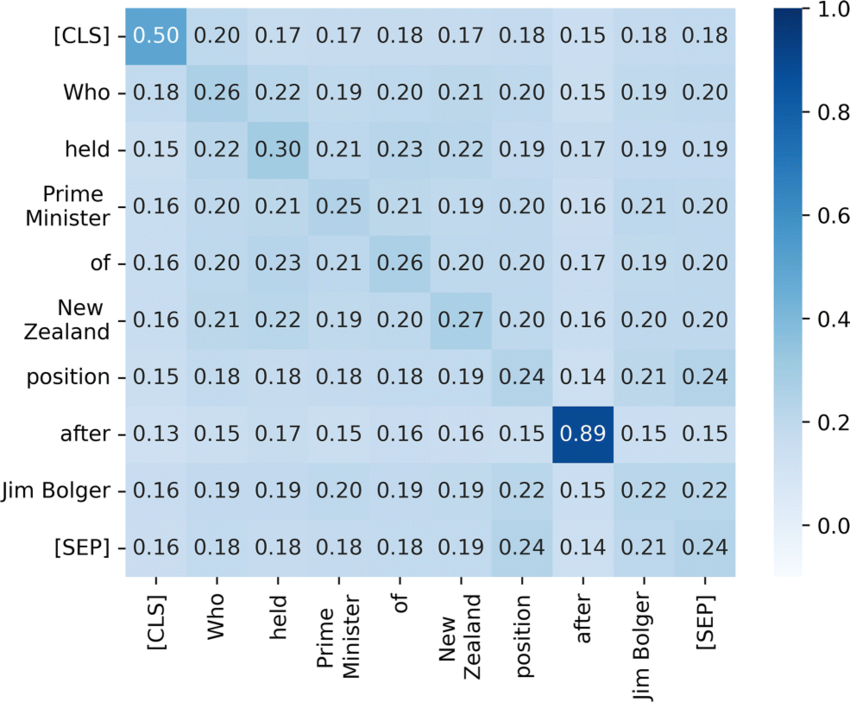

Masking

In [190]:
# tril = torch.tril(torch.ones(3, 3))
# print(tril)
tril = torch.tril(torch.ones(seq_len, seq_len))
print(tril)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


In [191]:
# test = torch.randn(3,3)
# test.masked_fill(tril == 0, float('-inf'))
mask = torch.tril(torch.ones(seq_len, seq_len, device=wei.device)).bool()
wei = wei.masked_fill(mask == 0, float('-inf'))
wei

tensor([[[-7.6121e-01,        -inf,        -inf,  ...,        -inf,
                 -inf,        -inf],
         [-1.4228e-01,  1.5422e-02,        -inf,  ...,        -inf,
                 -inf,        -inf],
         [-2.2158e-01, -7.2544e-02, -2.7892e-01,  ...,        -inf,
                 -inf,        -inf],
         ...,
         [ 5.5485e-01,  1.4600e-01,  8.0066e-01,  ..., -6.4179e-02,
                 -inf,        -inf],
         [-4.0005e-01,  1.2426e-01, -6.9860e-01,  ...,  3.0069e-01,
          -5.3851e-01,        -inf],
         [-3.9578e-01, -3.3827e-01, -5.7682e-01,  ...,  3.8438e-02,
           1.8634e-02, -2.8339e-02]],

        [[ 5.8294e-01,        -inf,        -inf,  ...,        -inf,
                 -inf,        -inf],
         [ 6.5861e-02,  1.6922e-01,        -inf,  ...,        -inf,
                 -inf,        -inf],
         [-1.9089e-01,  1.9064e-02,  2.0043e-01,  ...,        -inf,
                 -inf,        -inf],
         ...,
         [-8.2126e-02, -8

In [192]:
wei = F.softmax(wei, dim=-1)

In [210]:
wei[0][:8,:8] # 8 token display 

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4607, 0.5393, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3221, 0.3738, 0.3041, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2562, 0.2214, 0.1916, 0.3308, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2200, 0.1689, 0.1560, 0.2351, 0.2199, 0.0000, 0.0000, 0.0000],
        [0.1551, 0.1455, 0.1221, 0.1504, 0.1885, 0.2384, 0.0000, 0.0000],
        [0.1663, 0.1602, 0.1054, 0.1659, 0.1546, 0.1430, 0.1046, 0.0000],
        [0.0984, 0.1111, 0.0692, 0.1047, 0.1840, 0.0890, 0.1403, 0.2033]],
       grad_fn=<SliceBackward0>)

สงสัย ทำไมไม่ 1 diagonal